Evaluating best models after hyper-parameter tuning with 5-fold cross validation. Final soft label is based on the average of predicted soft labels from the five cross validation models. The best models are selected and saved by running the `rnn_main.py` file under the `Python` fold. The log files of the cross validation can be found in `output/rnn_hp.txt`.

===> Loading datasets
Train/Test data size: 4885/543
===> Evaluate test data


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


===> Best model:
RNN(
  (fc0): Linear(in_features=45, out_features=32, bias=True)
  (tanh): Tanh()
  (gru): GRU(32, 64, num_layers=3, batch_first=True, dropout=0.5)
  (fc1): Linear(in_features=64, out_features=2, bias=True)
)
______________________________________________
Classifier: RNN
Accuracy:  0.8987
AUC:  0.8410
AUPRC:  0.4588
Precision:  0.7222
Recall:  0.2063
F1-score:  0.3210
______________________________________________



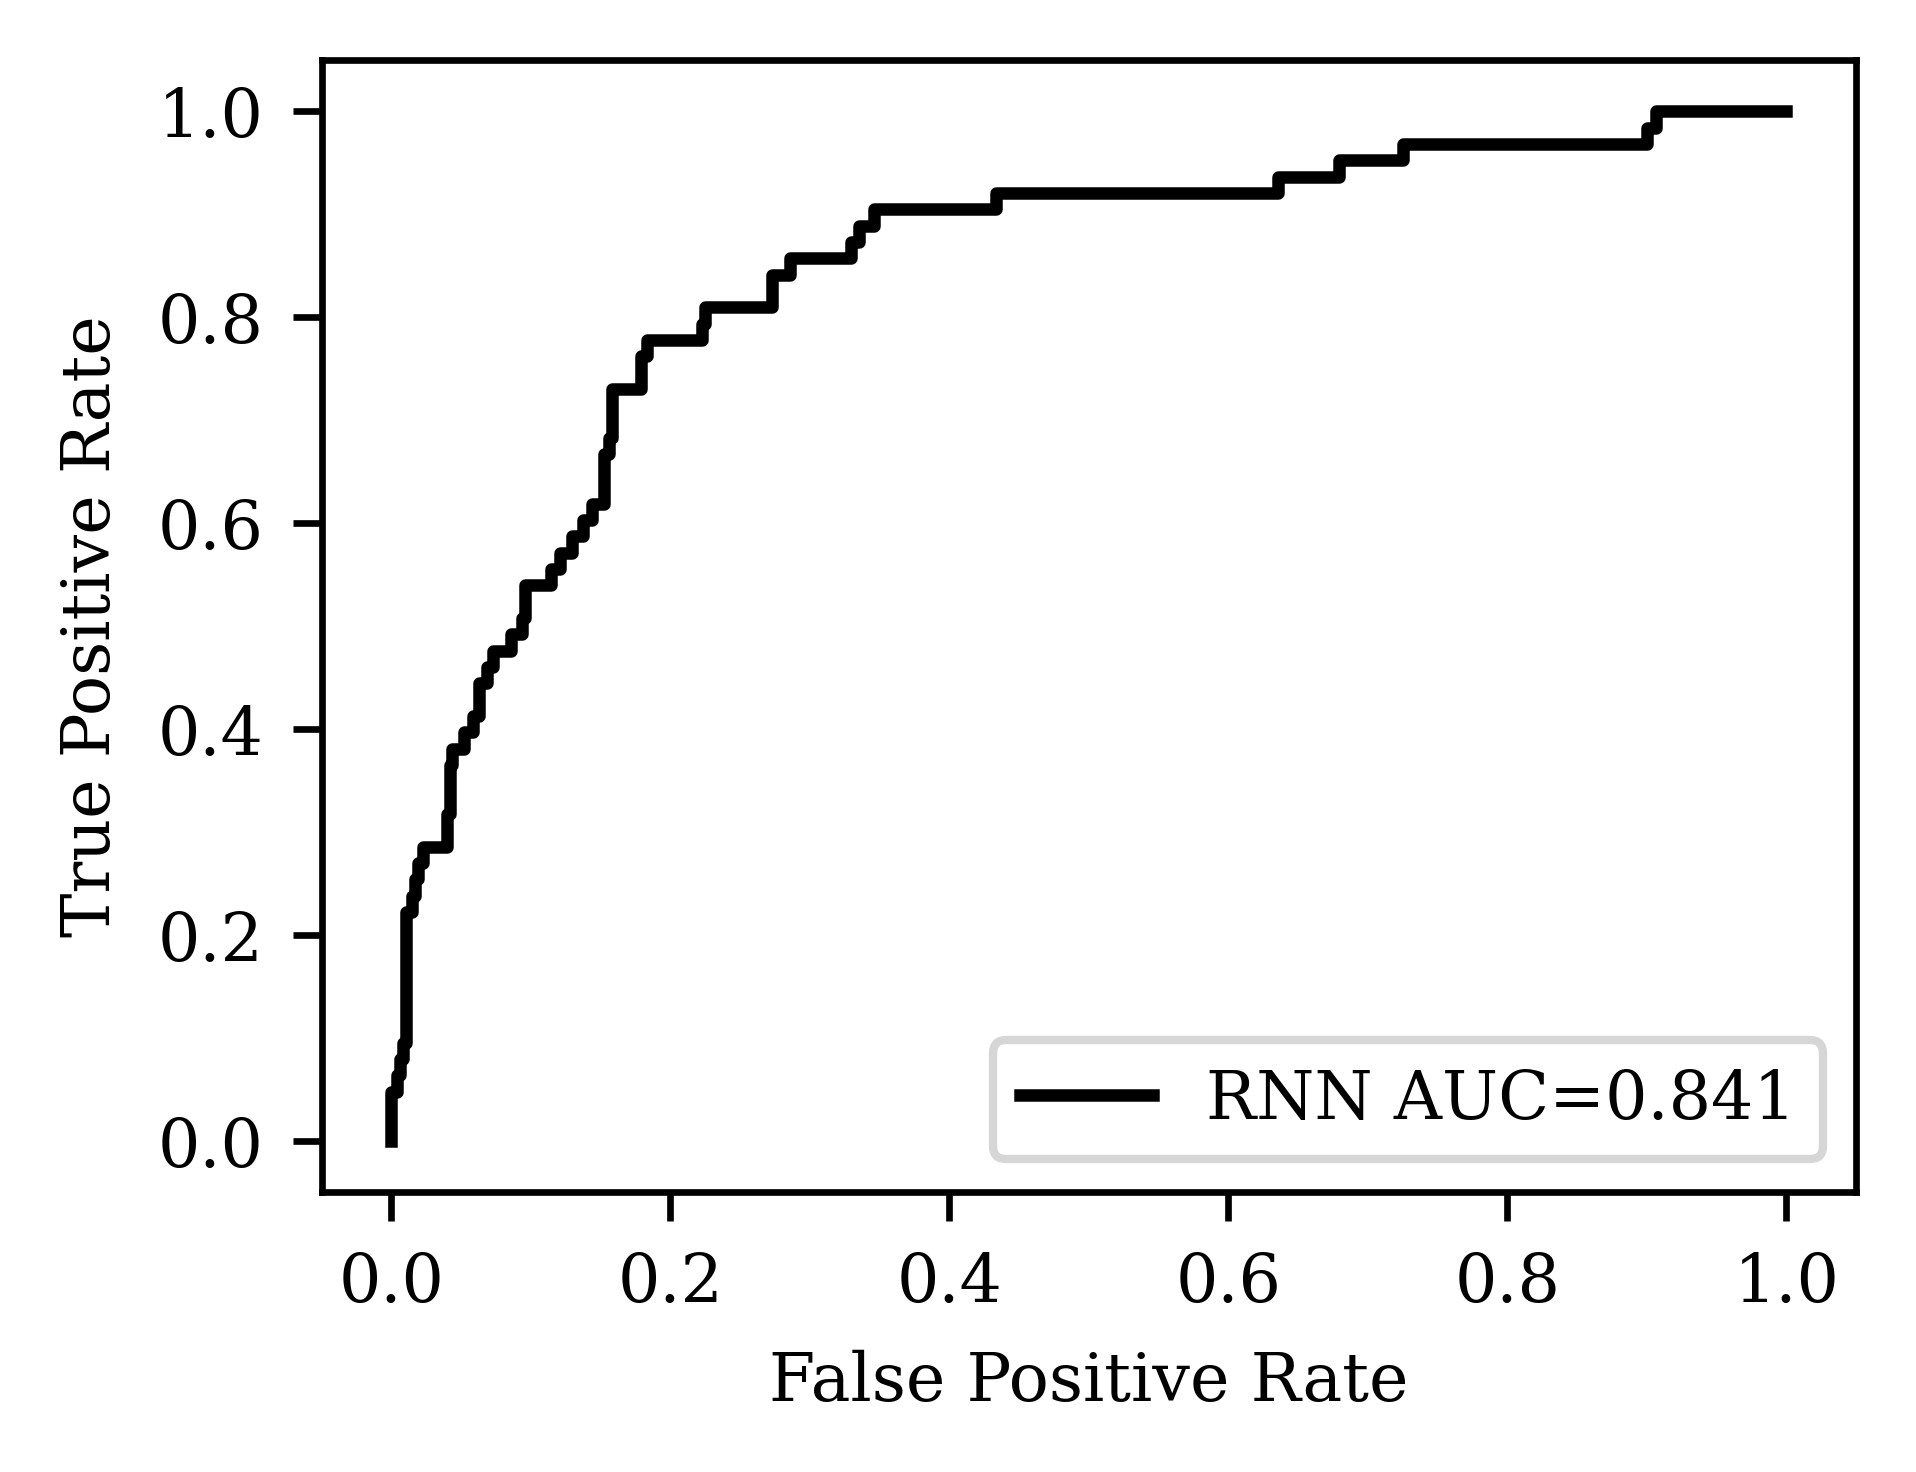

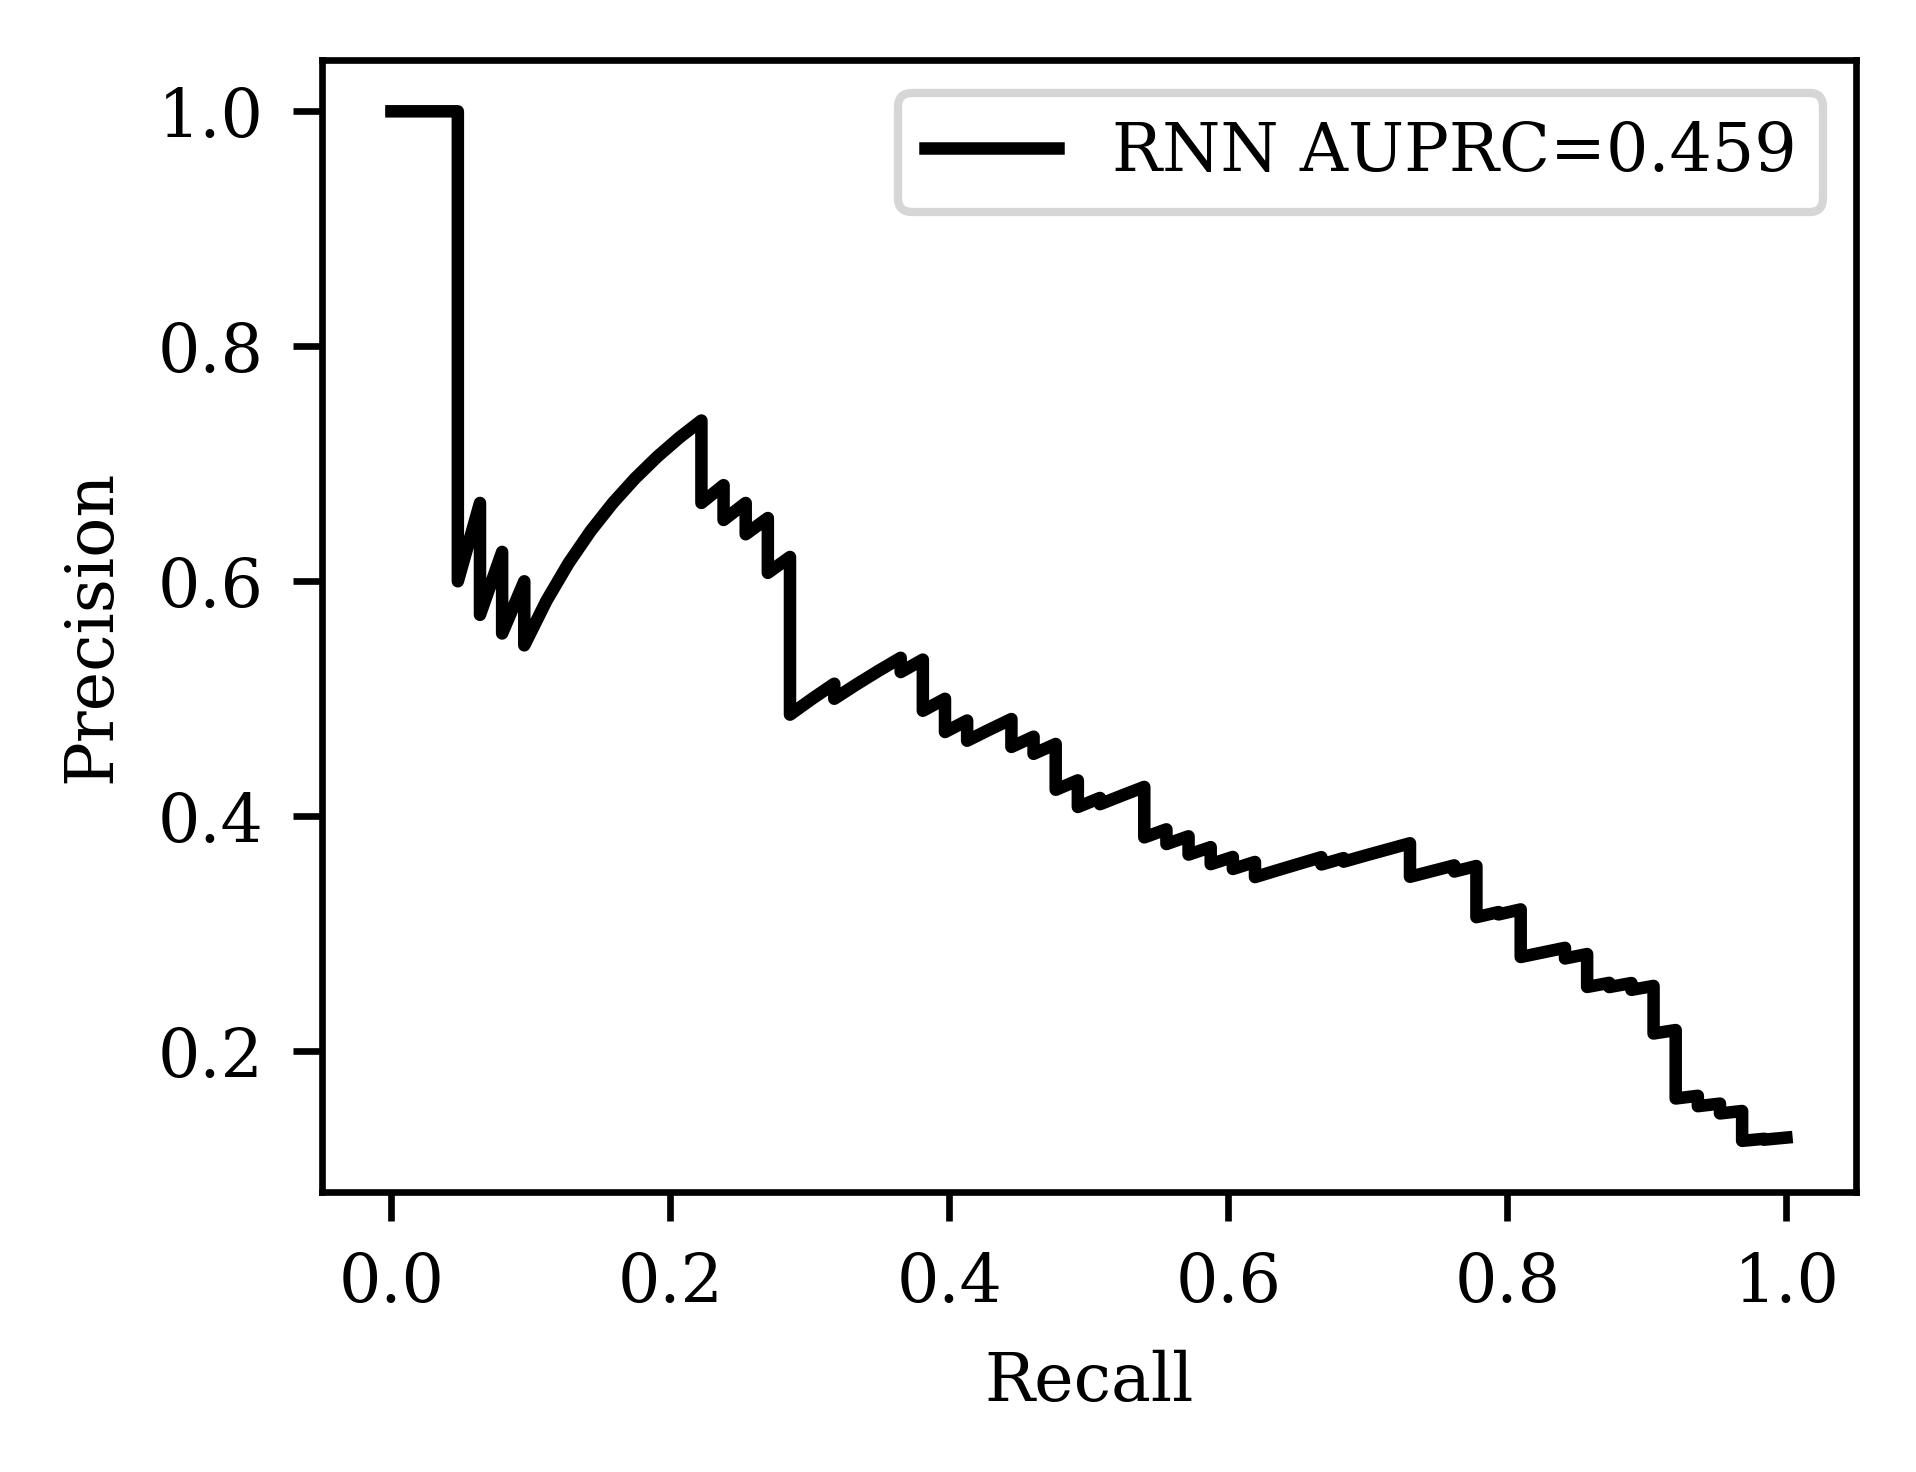

In [1]:
import os
import pickle
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from Python.model_data import model_data
from Python.rnn_data import VisitSequenceWithLabelDataset, seq_collate_fn
from Python.utils import classification_metrics, plot_roc, plot_prc

BATCH_SIZE = 32
USE_CUDA = True
NUM_WORKERS = 8

device = torch.device("cuda" if torch.cuda.is_available() and USE_CUDA else "cpu")

print('===> Loading datasets')

static_train, static_test, seq_train, seq_test = model_data("RNN", "Data", test_size=.1)

print('===> Evaluate test data')
y_test = static_test[['label']]
y_pred_cv = np.empty((y_test.size, 5))
for fold in range(5):
    scaler = pickle.load(open(f'output/rnn_scaler{fold}.pkl', 'rb'))
    model = torch.load(os.path.join("./output", f"rnn_model{fold}.pth"))
    scaled_x_test = scaler.transform(seq_test)
    scaled_x_test = pd.DataFrame(scaled_x_test, index=seq_test.index, columns=seq_test.columns)
    test_dataset = VisitSequenceWithLabelDataset(scaled_x_test, y_test)
    test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=seq_collate_fn, num_workers=NUM_WORKERS)

    model.eval()
    results = []

    with torch.no_grad():
        for i, (input, target) in enumerate(test_loader):

            input = tuple([e.to(device) if type(e) == torch.Tensor else e for e in input])
            target = target.to(device)

            output = model(input)

            y_true = target.detach().to('cpu').numpy().tolist()
            y_pred = nn.Softmax(1)(output).detach().to('cpu').numpy()[:,1].tolist()
            results.extend(list(zip(y_true, y_pred)))
        
        y_true, y_pred_cv[:, fold] = zip(*results)
        auc = roc_auc_score(y_true, y_pred_cv[:, fold])

print('===> Best model:')
print(model)

y_pred = y_pred_cv.mean(1)
classification_metrics("RNN", y_true, y_pred)
plot_roc(figname="output/RNN_roc.png", RNN="output/RNN_roc.csv")
plot_prc(figname="output/RNN_prc.png", RNN="output/RNN_prc.csv")